# model selection

My initial model was pretty random, somehow based on the homework for fashion MNIST.

I changed the 10 output classes to 2 and the b/w 1 channel input to 3 channels. The size of the images also had to be adjusted.

When I work with the face images I expect that a high resolution is necessary. We should need more detail than what is needed to distinguish b/w a jeans and a boot. I have images 256 x 256 which is more than enough for the human eye. I will work with 128x128 image size. 64x64 still looks ok to me personally, but I don't want to start out throwing information away too much ...

In [1]:
!pwd
main_dir = '/home/jovyan/LFI/bainbridge_2k/'

# location of original labels: LFI/bainbridge_2k/meta
label_file = '../meta/labels2k.xlsx'

images_dir = '../images/'
!ls $images_dir | wc -l #location for images , should output the number 2222

/home/jovyan/LFI/bainbridge_2k/code
2222


In [3]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install torch
!pip install torchvision
!pip install pytorch-model-summary

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# import os

import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms, utils

import PIL

import pytorch_model_summary as pms

# Dataset , DataLoader

In [5]:
class DS2kFaces(Dataset):
    
    def __init__(self , images_dir='../images/' , setup=None , transform=None): # setup is the df of filenames and labels
        self.transform = transform
        self.images_dir = images_dir
        self.setup = setup
        #self.all_imgs = self.setup.Filename
        
    def __len__(self):
        return self.setup.shape[0]

    def __getitem__(self, idx):
        img_loc = self.images_dir+self.setup.Filename[idx]
        img = PIL.Image.open(img_loc)
        tensor_image = self.transform(img)
        # return image and label , label is 0/1 and not 1-hot-encoded 
        # https://discuss.pytorch.org/t/runtimeerror-multi-target-not-supported-newbie/10216
        return tensor_image,self.setup.Gender[idx]

In [9]:
# https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
# answered Dec 2018 . Too old??

df = pd.read_excel(label_file, sheet_name='Final Values')[['Filename','Gender','Age','Race']]    
setup = df.copy()

for idx , fn in enumerate(df.Filename):
    setup.loc[idx, 'Filename']=df.iloc[idx].Filename.replace(" ","").replace("(","").replace(")","")
    #fn_new = df.iloc[idx].Filename.replace(" ","").replace("(","").replace(")","")
    #setup.loc[idx, 'Filename'] = fn_new

# print(setup.shape)

# initial transform , before normalizing, for both training and test set.
imgW= 128 # 128 for models 1,6 , 64 for models 2 , 3
imgH= 128 # 128
transform = transforms.Compose([
    transforms.Resize((imgW,imgH)), 
    transforms.ToTensor()
])

dataset = DS2kFaces(setup=setup , transform=transform)
# dataset = CustomDatasetFromCSV(my_path)

batch_size = 10
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

fh = open(main_dir+'meta/test_indices.txt', 'w') 
for idx in test_indices:
    fh.write(str(idx)+',')
fh.close() 

fh = open(main_dir+'meta/train_indices.txt', 'w') 
fh.write(str(train_indices)+',') 
fh.close() 

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)


In [10]:
def inspect_batch(btch):
    batch_tensor = btch[0]
    grid_img = torchvision.utils.make_grid(batch_tensor, nrow=5)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    print('labels : ' , btch[1])
    #preds =  torch.max(model(btch[0]),1)[1]
    #print('predictions : ' , preds)

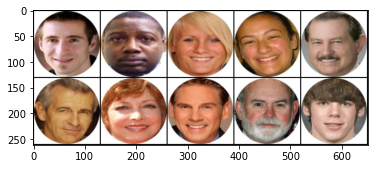

labels :  tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1])


In [11]:
inspect_batch(next(iter(test_loader)))

# define the models

In [3]:
from myModels import myModels as mm # mm = myModels

In [14]:
# almost 100.000 learnable parameters, images of size 128x128
mm6 = mm.MyNeuralNetwork6()
print(pms.summary(mm6, torch.zeros((1, 3, 128, 128)), show_input=True))

-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 128, 128]             672             672
       MaxPool2d-2     [1, 24, 128, 128]               0               0
       Dropout2d-3       [1, 24, 63, 63]               0               0
          Conv2d-4       [1, 24, 63, 63]           5,208           5,208
       MaxPool2d-5       [1, 24, 63, 63]               0               0
       Dropout2d-6       [1, 24, 31, 31]               0               0
          Conv2d-7       [1, 24, 31, 31]           5,208           5,208
       MaxPool2d-8       [1, 24, 31, 31]               0               0
       Dropout2d-9       [1, 24, 15, 15]               0               0
         Linear-10             [1, 5400]          86,416          86,416
         Linear-11               [1, 16]              34              34
Total params: 97,538
Trainable params: 97,538
Non-

In [28]:
mm2 = mm.MyNeuralNetwork2()
print(pms.summary(mm2, torch.zeros((1, 3, 64, 64)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 64, 64]             896             896
          Conv2d-2     [1, 32, 64, 64]           9,248           9,248
       MaxPool2d-3     [1, 32, 64, 64]               0               0
       Dropout2d-4     [1, 32, 31, 31]               0               0
          Linear-5          [1, 30752]          61,506          61,506
          Linear-6              [1, 2]               6               6
Total params: 71,656
Trainable params: 71,656
Non-trainable params: 0
-----------------------------------------------------------------------


In [36]:
# has less than 8000 learnable parameters, works on size 64x64 images
mm3 = mm.MyNeuralNetwork3()
print(pms.summary(mm3, torch.zeros((1, 3, 64, 64)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 64, 64]             112             112
       MaxPool2d-2      [1, 4, 64, 64]               0               0
       Dropout2d-3      [1, 4, 31, 31]               0               0
          Linear-4           [1, 3844]           7,690           7,690
          Linear-5              [1, 2]               6               6
Total params: 7,808
Trainable params: 7,808
Non-trainable params: 0
-----------------------------------------------------------------------


## Train and test

In [15]:
def training(model, data_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for batch_idx, (inputs, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        #print('inputs : ' , inputs)

        labels = labels.to(device)
        # print('labels : ' , labels)

        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)

        # backward
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        # print('inputs.size(0)' , inputs.size(0)) # this is the batch size
        running_corrects += torch.sum(preds == labels.data)
        #print('running_corrects : ' , running_corrects.item())
        #print('diff in labels and preds : ' , [i-j for (i,j) in zip(labels.tolist(), preds.tolist())])
        
        if batch_idx % 50 == 0:
            print(f'Training Batch: {batch_idx:4} of {len(data_loader)}')

    epoch_loss = running_loss / ( len(data_loader) * batch_size )
    # epoch_acc = running_corrects.double() /  len(data_loader.dataset) ) # divides by 2222
    epoch_acc = running_corrects.double() /  ( len(data_loader) * batch_size )
    #print('calculate accuracy : ' , running_corrects.item() , len(data_loader) , inputs.size(0))
    
    print('-' * 10)
    print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')
    
    return epoch_loss, epoch_acc

In [16]:
def test(model, data_loader, criterion, device):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    err_0 = 0 
    err_1 = 0
    
    # do not compute gradients
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            # documentation
            # save some info in a data frame
            # how do I know which image I am working on? Pass Filename similar to label?
            
            # statistics
            running_loss += loss.item() * inputs.size(0) # is loss.item() already the average loss, so divided by the batch size??
            running_corrects += torch.sum(preds == labels.data)
            #print('diff in labels and preds : ' , [i-j for (i,j) in zip(labels.tolist(), preds.tolist())])
            #print('running_corrects : ' , running_corrects.item())
            err_0 +=  torch.sum(preds > labels.data) # predict 1(m) for true 0(f)
            err_1 +=  torch.sum(preds < labels.data) # predict 0(f) for true 1(m)
            
            if batch_idx % 10 == 0:
                print(f'Test Batch: {batch_idx:4} of {len(data_loader)}')

        epoch_loss = running_loss / ( len(data_loader) * batch_size )
        epoch_acc = running_corrects.item() / ( len(data_loader) * batch_size ) # inputs.size(0) refers to the last batch and that may be smaller than the batch_size

    print('-' * 10)
    print(f'Test Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

    return epoch_loss, epoch_acc, err_0 , err_1

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("torch.cuda.is_available(): ", torch.cuda.is_available())
# set seed for reproducability
torch.manual_seed(1999)

num_epochs = 50 # 150 when things run smoothly
learning_rate = 0.001
momentum = 0.9

## model setup
model = mm6.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() # gender classification is a binary task , BCE binary cross entropy
# the model output has to be different from my current model. So I stay with the more general

print('**', model)

train_acc_history = []
test_acc_history = []

train_loss_history = []
test_loss_history = []

test_err_0_history = []
test_err_1_history = []

best_acc = 0.0
#since = time.time()

for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # train
    training_loss, training_acc = training(model, train_loader, optimizer, criterion, device)
    train_loss_history.append(training_loss)
    train_acc_history.append(training_acc)

    # test
    test_loss, test_acc, test_err_0, test_err_1 = test(model, test_loader, criterion, device)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    test_err_0_history.append(test_err_0)
    test_err_1_history.append(test_err_1)

    # overall best model
    if test_acc > best_acc:
        best_acc = test_acc
        #best_model_wts = copy.deepcopy(model.state_dict())

print(f'Best acc in test: {best_acc:4f}')


torch.cuda.is_available():  True
** MyNeuralNetwork6(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=5400, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
)
Epoch 0/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.6865 Acc: 0.5596

Test Batch:   

Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.2795 Acc: 0.8921

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.3122 Acc: 0.8578

Epoch 23/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.2746 Acc: 0.8916

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.2976 Acc: 0.8578

Epoch 24/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.2607 Acc: 0.8966

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.2873 Acc: 0.8622

Epoch 25/49
----------
Training Batch

----------
Training Loss: 0.1818 Acc: 0.9270

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.2365 Acc: 0.8889

Epoch 47/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.1647 Acc: 0.9360

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.2568 Acc: 0.8867

Epoch 48/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch:  150 of 178
----------
Training Loss: 0.1619 Acc: 0.9337

Test Batch:    0 of 45
Test Batch:   10 of 45
Test Batch:   20 of 45
Test Batch:   30 of 45
Test Batch:   40 of 45
----------
Test Loss: 0.2423 Acc: 0.8933

Epoch 49/49
----------
Training Batch:    0 of 178
Training Batch:   50 of 178
Training Batch:  100 of 178
Training Batch

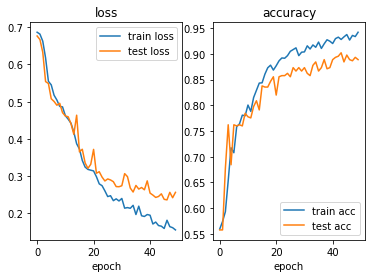

In [18]:
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('epoch')
plt.title('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='train acc')
plt.plot(test_acc_history, label='test acc')
plt.xlabel('epoch')
plt.title('accuracy')
plt.legend()
plt.show()

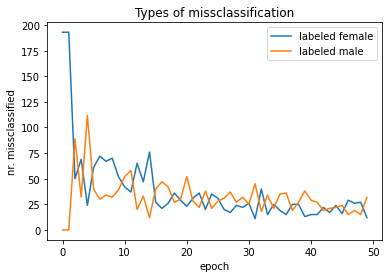

In [19]:
plt.plot(test_err_0_history, label='labeled female')
plt.plot(test_err_1_history, label='labeled male')
plt.xlabel('epoch')
plt.ylabel('nr. missclassified')
plt.title('Types of missclassification')
plt.legend()

## documentation of classification errors during training process
only for the test images. I have to make sure I am accessing the training images and can identify each image. I need to know how the classification of each image changes over time. Create an time series for each test image.

In [20]:
def misclassified_in_batch(btch):
    '''plot misclassified images'''
    for idx_images in range(btch[0].shape[0]): # for each image in the badge , first dim is batch size or Nr. images in batch: NxCxHxW
        pred =  torch.max(model(btch[0]),1)[1]
        if btch[1][idx_images] != pred: # label != prediction
            plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

In [21]:
def misclass_show(model, data_loader, device):
    model.eval() # no dropout for evaluation / classification

    # do not compute gradients
    with torch.no_grad(): # not calsulating gradients for evaluation / classification

        for batch_idx, (inputs, labels) in enumerate(data_loader):
            print('batch nr : ' , batch_idx)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            preds = preds.tolist()
            for idx_images in range(len(inputs)):
                print(labels[idx_images].item() , preds[idx_images])
                if labels[idx_images].item() != preds[idx_images]: # label == prediction
                    plt.figure(figsize=(2, 2))
                    plt.imshow(inputs[idx_images,:,:,:].permute(1, 2, 0).cpu().numpy())
            plt.show()

In [ ]:
misclass_show(model, test_loader, device)

In [24]:
def misclass_count(model, data_loader, device):
    model.eval() # no dropout for evaluation / classification
    
    err_lab_0 = 0
    err_lab_1 = 0

    # do not compute gradients
    with torch.no_grad(): # not calsulating gradients for evaluation / classification

        for batch_idx, (inputs, labels) in enumerate(data_loader):
            #print('batch nr : ' , batch_idx)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            labels = labels.tolist()
            preds = preds.tolist()
            
            diff = [i-j for (i,j) in zip(labels,preds)]
                 
            err_lab_0 += diff.count(-1)
            err_lab_1 += diff.count(1)
    return {'error label 0': err_lab_0, 'error label 1': err_lab_1}

In [25]:
misclass_count(model, test_loader, device)

{'error label 0': 12, 'error label 1': 32}

Compare the two models statistically

have 10 different random seeds, run the train and test and document total errors in the test set and errors for the separate genders.

We will be interested in the test accuracy and the errors for the genders.

AND get the ethnicity in the loop! Do that before running statistics.

And should we document errors at the end of the training, afer 20 or 50 epochs?

I HAVE TO MAKE DEV SPLIT FROM THE TEST SPLIT!! 80/10/10 ??!!

TRY TO DO HPO with autotorch before comparing models.